# Циклическое изменение learning rate для ускорения сходимости

Недостатком адаптивных оптимизаторов является необходимость хранения в памяти квадратов градиентов. Для циклического learning rate это необязательно, его можно использовать с SGD, изменяя скорости в 3–4 раза. Аналогично с Adam — это позволит редким признакам быстрее обучаться (частые признаки будут немного “ломаться”, а затем восстанавливаться). Для таких целей важно подбирать learning rate вблизи оптимального. Идея этого представлена в [статье 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf).


Циклическое изменение  learning rate для ускорения сходимости реализовано в PyTorch в `optim.lr_scheduler.CyclicLR`.

Делать это можно по-разному (`mode` — параметр, передаваемый `CyclicLR`):

1. Постоянно оставлять одни и те же границы `mode='triangular'`.




<img src ="https://ml.gan4x4.ru/msu/additions/L07/cyclical_learning_schedule_permanent_confines.png" width="600">


2. Уменьшать верхнюю границу во сколько-то раз: `mode='triangular2'` — уменьшение в 2 раза.

<img src ="https://ml.gan4x4.ru/msu/additions/L07/cyclical_learning_schedule_reduce_confines.png" width="600">

3. Уменьшать границу экспоненциально ($\text{amplitude}_\text{iterations
 } = \text{amplitude}_0⋅\gamma^\text{iterations}$, где $0<\gamma\leq1$), `mode='exp_range'`.

<img src ="https://ml.gan4x4.ru/msu/additions/L07/cyclical_learning_schedule_reduce_confines_smooth.png" width="600">

4. По собственной формуле с использованием `scale_fn`.

## Подбираем границы learning rate



In [ ]:
import random
import torch
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Сделаем батч побольше, чтобы учить модель быстрее.



In [ ]:
import torchvision

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

# transforms for data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.13), (0.3))
])

train_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

clear_output()
print("Already downloaded!")

batch_size = 32 * 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Already downloaded!


Модель:

In [ ]:
import torch
import torch.nn as nn

class SimpleMNIST_NN_Init_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)
        self.init()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("sigmoid")
        for child in self.layers.children():
            if isinstance(child, nn.Linear):
                torch.nn.init.xavier_normal_(child.weight, gain=sigmoid_gain)
                if child.bias is not None:
                    torch.nn.init.zeros_(child.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)

Для определения оптимального learning rate будем обучать модель 2 эпохи (в статье 8 эпох, но MNIST — очень простой датасет) и смотреть на accuracy на тестовой выборке для различных значений.

In [ ]:
def get_correct_count(pred, labels):
    _, predicted = torch.max(pred.data, 1)
    return (predicted.cpu() == labels.cpu()).sum().item()


@torch.inference_mode()  # this annotation disable grad computation
def get_accuracy(model, test_loader, device="cpu"):
    correct, total = 0, 0
    for imgs, labels in test_loader:
        pred = model(imgs.to(device))
        total += labels.size(0)
        correct += get_correct_count(pred, labels)
    return correct / total

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

lr_find_epochs = 2
lrs = [0.0002 + 0.0005 * i for i in range(10)]
losses = []
test_accuracy = []

for lr in tqdm(lrs):
    set_random_seed(42)
    model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for iter in range(lr_find_epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            x_train, y_train = batch
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            loss.backward()
            optimizer.step()
            loss = loss.detach().cpu().numpy()

    losses.append(loss)
    acc = get_accuracy(model, test_loader, device=device)
    test_accuracy.append(acc)

  0%|          | 0/10 [00:00<?, ?it/s]

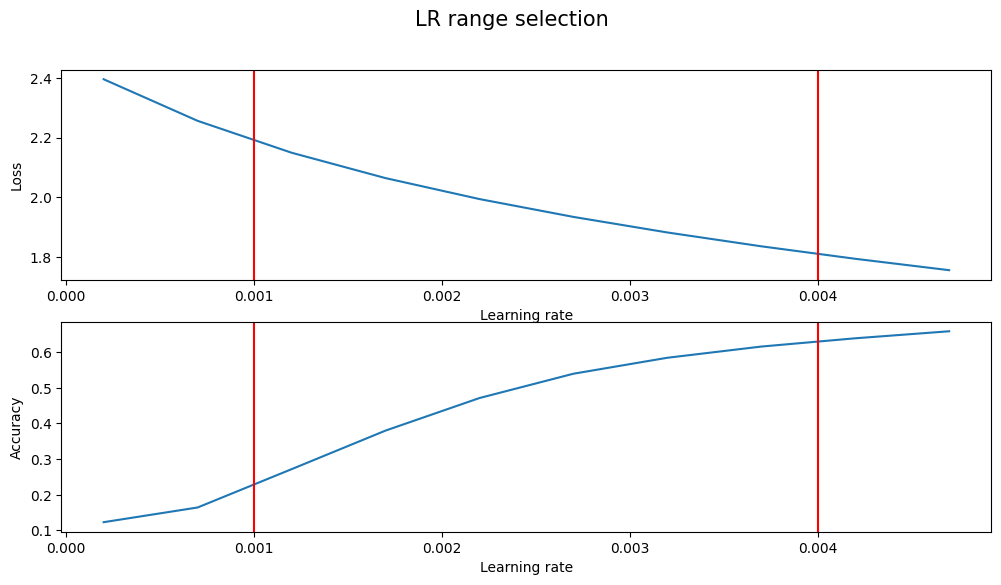

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle("LR range selection", size=15)

ax1.plot(lrs, losses)
ax1.set(xlabel="Learning rate", ylabel="Loss")
ax1.axvline(x=0.001, color="r")
ax1.axvline(x=0.004, color="r")

ax2.plot(lrs, test_accuracy)
ax2.set(xlabel="Learning rate", ylabel="Accuracy")
ax2.axvline(x=0.001, color="r")
ax2.axvline(x=0.004, color="r")

plt.show()

Нас интересует диапазон learning rate, при котором качество начинает сильно расти. Возьмем минимальное значение learning rate $1\cdot10^{-3}$ и максимальное  learning rate $4\cdot10^{-3}$. Максимальное больше минимального в 4 раза (в [статье 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf) рекомендуют 3–4).


In [ ]:
base_lr = 1e-3
max_lr = 4e-3

Этот `scheduler` надо применять после каждого батча. Поэтому перепишем `train_epoch_sh`:

In [ ]:
def train_epoch_sh(model, optimizer, scheduler, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().numpy())  # write loss to log
        loss.backward()
        optimizer.step()
        scheduler.step()
    return loss_history

Функция для валидации сети на валидационной выборке:

In [ ]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

## Запускаем

Код для визуализации:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

Вернем размер батча для корректного сравнения.

In [ ]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Размер шага learning rate рекомендуют выбирать каждые 2–8 эпох. Мы возьмем 4.

In [ ]:
step_size_up = 4 * len(train_loader)
print(step_size_up)

7500


In [ ]:
set_random_seed(42)
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=base_lr)

scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    mode="triangular",
    step_size_up=step_size_up,
)  # first case

В коде ниже мы на каждой эпохе сохраняем лучшую модель.

In [ ]:
import numpy as np
from copy import deepcopy


def train_model_cycle_sh(model, optimizer, scheduler, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs

    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    best_loss = np.inf

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch_sh(
            model, optimizer, scheduler, criterion, train_loader
        )
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)

    return best_model, train_history


model_name = "sgd_cycle_lr"
best_model, history = train_model_cycle_sh(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)
history_plotter.add(history)

  0%|          | 0/5 [00:00<?, ?it/s]

Сравним с SGD и Adam:

In [ ]:
def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history


def train_model_sep(model, optimizer, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
    return train_history

In [ ]:
set_random_seed(42)
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

model_name = "sgd"
history = train_model_sep(model, optimizer, model_name=model_name)
history_plotter.add(history)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
set_random_seed(42)
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

model_name = "adam"
history = train_model_sep(model, optimizer, model_name="adam")
history_plotter.add(history)

  0%|          | 0/5 [00:00<?, ?it/s]

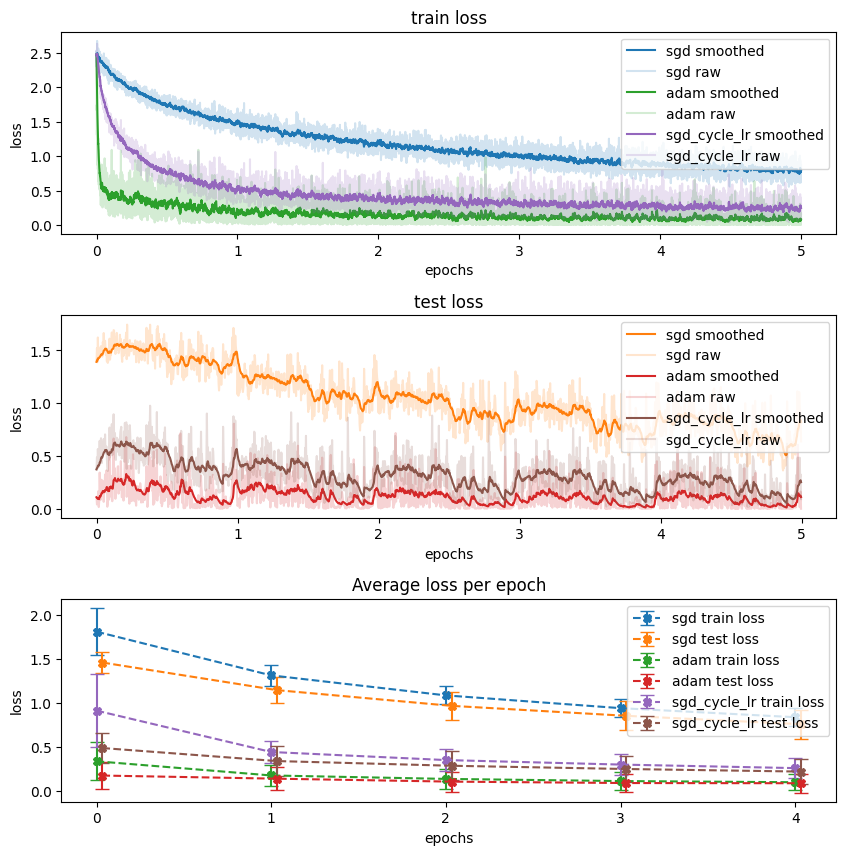

In [ ]:

history_plotter.plot(["sgd", "adam", "sgd_cycle_lr"])

Получилось хуже, чем Adam, но лучше, чем SGD, и мы сэкономили память.